In [28]:
from sklearn.decomposition import PCA
from scipy import sparse
import pickle
import pandas as pd

from Constants import *
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

### Load data

In [25]:
newspaper_speaker_tfidf = sparse.load_npz(FILE_NEWSPAPER_SPEAKER_TFIDF)
newspaper_speaker_tfidf = newspaper_speaker_tfidf.toarray()

with open(PICKLE_NEWSPAPER_TO_INDEX, 'rb') as handle:
    newspaper_to_index = pickle.load(handle)

with open(PICKLE_INDEX_TO_NEWSPAPER, 'rb') as handle:
    index_to_newspaper = pickle.load(handle)
    
newspaper_owner = pd.read_csv(FILE_NEWSPAPER_OWNER)

### Select newspaper that are owned by a groupe with multiple newspaper

In [3]:

newspaper_with_owner = newspaper_owner[~newspaper_owner["owner"].isnull()]

print(f'We sucessfully retieved: {len(newspaper_with_owner) / len(newspaper_owner) * 100}% of the data')

num_np_by_owner = newspaper_with_owner.groupby("owner").count()["newspaper"]

group_owner = set(num_np_by_owner[num_np_by_owner > 2].index)

newspaper_in_group = newspaper_with_owner[newspaper_with_owner["owner"].isin(group_owner)]

newspaper_in_group

We sucessfully retieved: 13.61043194784026% of the data


,newspaper,QID,website,owner
2,1045theteam,Q7956286,http://www.1045theteam.com,Townsquare Media
4,107jamz,Q6331512,http://www.107jamz.com,Townsquare Media
5,10news,Q3191396,http://www.10news.com/,E. W. Scripps Company
8,13abc,Q2386816,http://www.13abc.com/,Gray Television
16,247sports,Q16973497,https://247sports.com/,ViacomCBS Streaming
...,...,...,...,...
7310,yardbarker,Q8049272,http://www.yardbarker.com/,Fox Entertainment Group
7321,yorkpress,Q7758091,http://www.yorkpress.co.uk/,Newsquest
7323,yorkshirecoastradio,Q8055687,http://www.yorkshirecoastradio.com/,UKRD Group
7349,zap2it,Q8066356,http://www.zap2it.com/,Tribune Media


In [4]:
newspaper_in_group.owner = pd.Categorical(newspaper_in_group.owner)
newspaper_in_group['owner_ID'] = newspaper_in_group.owner.cat.codes


/usr/local/Caskroom/miniconda/base/envs/ada/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/var/folders/vq/xks_4c213rdb38bljjc08hpr0000gp/T/ipykernel_6169/1626499716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newspaper_in_group['owner_ID'] = newspaper_in_group.owner.cat.codes


In [5]:
newspaper_in_group

,newspaper,QID,website,owner,owner_ID
2,1045theteam,Q7956286,http://www.1045theteam.com,Townsquare Media,59
4,107jamz,Q6331512,http://www.107jamz.com,Townsquare Media,59
5,10news,Q3191396,http://www.10news.com/,E. W. Scripps Company,14
8,13abc,Q2386816,http://www.13abc.com/,Gray Television,23
16,247sports,Q16973497,https://247sports.com/,ViacomCBS Streaming,65
...,...,...,...,...,...
7310,yardbarker,Q8049272,http://www.yardbarker.com/,Fox Entertainment Group,16
7321,yorkpress,Q7758091,http://www.yorkpress.co.uk/,Newsquest,40
7323,yorkshirecoastradio,Q8055687,http://www.yorkshirecoastradio.com/,UKRD Group,62
7349,zap2it,Q8066356,http://www.zap2it.com/,Tribune Media,60


In [39]:
newspaper_in_group.owner.nunique()

73

### Project speaker TFIDF in 2D using PCA /TSNE an create a map

In [43]:
def project2D_PCA(selected_newspapers, newspaper_to_index, X):
    newspaper_in_group_idx = [newspaper_to_index[newspaper] for newspaper in selected_newspapers]
    selected_X = X[newspaper_in_group_idx]
    
    pca = PCA(n_components=2)
    Y = pca.fit_transform(selected_X)
    return Y

In [44]:
def project2D_and_map_PCA(selected_newspapers, newspaper_to_index, X, colors):
    Y = project2D_PCA(selected_newspapers, newspaper_to_index, X)
    
    plt.scatter(Y[:, 0], Y[:, 1], c=colors, cmap=plt.cm.Spectral)
    plt.show()
    
    return Y

In [32]:
def project2D_and_map_TSNE(selected_newspapers, newspaper_to_index, X, colors):
    newspaper_in_group_idx = [newspaper_to_index[newspaper] for newspaper in selected_newspapers]
    selected_X = X[newspaper_in_group_idx]
    
    distance_matrix = pairwise_distances(selected_X, metric='cosine')
    embeddings = TSNE(n_components=2,metric='precomputed',square_distances=True)
    Y_tsne = embeddings.fit_transform(distance_matrix)
    
    plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], c=colors, cmap=plt.cm.Spectral)
    plt.show()
    
    return Y_tsne

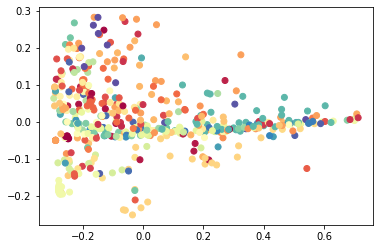

array([[ 0.41794924, -0.00426079],
       [ 0.10571833, -0.02366805],
       [-0.18374581,  0.09602836],
       ...,
       [-0.25755774, -0.11126563],
       [ 0.28363499, -0.02034924],
       [ 0.13391762, -0.02745436]])

In [45]:
project2D_and_map_PCA(newspaper_in_group.newspaper, newspaper_to_index, newspaper_speaker_tfidf, newspaper_in_group.owner_ID)


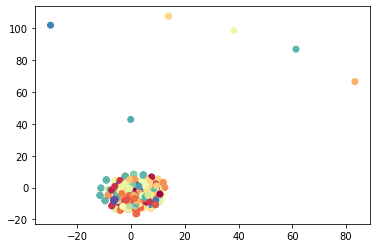

array([[-1.4726324 , -4.442316  ],
       [ 7.6362987 , -7.146496  ],
       [ 0.04950082, -7.1040483 ],
       ...,
       [ 2.9087374 ,  0.84346694],
       [ 5.3096275 , -5.958432  ],
       [ 6.256965  , -4.961109  ]], dtype=float32)

In [33]:
project2D_and_map_TSNE(newspaper_in_group.newspaper, newspaper_to_index, newspaper_speaker_tfidf, newspaper_in_group.owner_ID)


### Project token TFIDF in 2D using PCA /TSNE an create a map

In [35]:
newspaper_token_tfidf = sparse.load_npz(FILE_NEWSPAPER_TOKEN_TFIDF)
newspaper_token_tfidf = newspaper_token_tfidf.toarray()

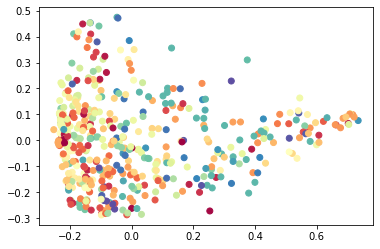

array([[ 0.53416246,  0.07857406],
       [ 0.20977762,  0.08596652],
       [-0.13724241, -0.1985384 ],
       ...,
       [-0.22121525,  0.04208206],
       [ 0.6340936 ,  0.08736885],
       [ 0.14483158, -0.21131902]])

In [36]:
project2D_and_map_PCA(newspaper_in_group.newspaper, newspaper_to_index, newspaper_token_tfidf, newspaper_in_group.owner_ID)


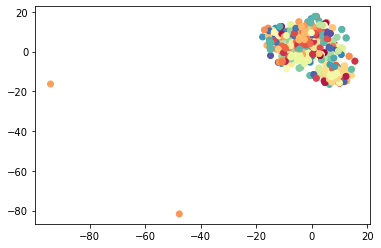

array([[  6.305992  , -16.535042  ],
       [-13.481176  ,   6.4323254 ],
       [ -0.4233342 ,   5.4268985 ],
       ...,
       [  8.22946   ,  -7.4696274 ],
       [-11.541415  ,  12.643819  ],
       [  9.511651  ,   0.27680993]], dtype=float32)

In [37]:
project2D_and_map_TSNE(newspaper_in_group.newspaper, newspaper_to_index, newspaper_token_tfidf, newspaper_in_group.owner_ID)


### Bokeh plot of the above map

In [79]:
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import Turbo256, Plasma, cividis, magma
from bokeh.models import LabelSet
import bokeh.plotting as bpl
from bokeh.transform import factor_cmap

In [46]:
Y =  project2D_PCA(newspaper_in_group.newspaper, newspaper_to_index, newspaper_speaker_tfidf)

In [51]:
df = pd.DataFrame(
    {
        "x": Y[:, 0],
        "y": Y[:, 1],
        "group": newspaper_in_group.owner
    }
)

In [83]:
source = bpl.ColumnDataSource(df)

# use whatever palette you want...
#palette = Turbo256[len(df['group'].unique())]
color_map = factor_cmap("group", factors=sorted(df['group'].unique()),palette=magma(len(df['group'].unique())))

# create figure and plot
p = bpl.figure(height=1000, width=1500)
p.scatter(x='x', y='y',
          fill_color= color_map,
          line_color = color_map,
          legend='group', source=source)

p.legend.click_policy="hide"

labels = LabelSet(x='x', y='y', text='group',
              x_offset=5, y_offset=5, source=source, render_mode='canvas')

p.add_layout(labels)
bpl.show(p)
